In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize

import warnings as w
w.simplefilter('ignore')

In [145]:
def statistics(y_test, y_pred, y_prob, n_classes):
    # Додаткова статистика
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Виведення текстових значень метрик
    print("\nКласифікаційний звіт:\n", classification_report(y_test, y_pred), '\n')
    
    # Візуалізація метрик у вигляді стовпчастого графіка
    metrics = ['precision', 'recall', 'f1-score']
    classes = list(report.keys())[:-3]  # Отримаємо всі класи (окрім 'accuracy', 'macro avg', 'weighted avg')
    
    # Створюємо окремі графіки для кожної метрики
    fig, ax = plt.subplots(1, len(metrics), figsize=(18, 6))
    for i, metric in enumerate(metrics):
        values = [report[class_name][metric] for class_name in classes]
        ax[i].bar(classes, values, color='b', alpha=0.7)
        ax[i].set_title(metric.capitalize())
        ax[i].set_xlabel('Класи')
        ax[i].set_ylabel('Значення')
        ax[i].set_ylim(0, 1)  # Значення метрик від 0 до 1
        ax[i].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Візуалізуємо матрицю плутанини
    conf_matrix = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot(cmap='Blues')
    plt.show()

    # Підготовка для побудови ROC-кривих
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))  # Бінаризація для багатокласової задачі
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Обчислюємо значення для кожного класу
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Побудова багатокласової ROC-кривої
    plt.figure(figsize=(10, 8))
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green']  # Можна додати більше кольорів для багатокласових задач
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC клас {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-крива для багатокласової класифікації')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [146]:
df = pd.read_csv('pets_train.csv')

In [147]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,AdoptionSpeed
0,0.888976,-0.482642,-0.138319,0.241295,-0.939669,0.370179,0.095937,-0.148803,-0.617469,0.516561,...,-0.569885,-0.088423,-0.119005,-0.068385,-0.154365,-0.217063,-0.027864,0.802579,-0.055793,1
1,0.888976,-0.420591,1.202231,-1.727243,0.629286,0.370179,0.095937,-0.148803,-0.133040,-0.323985,...,-0.569885,-0.088423,-0.119005,-0.068385,-0.154365,-0.217063,-0.027864,0.802579,-0.055793,1
2,0.888976,-0.420591,1.202231,-1.727243,-0.939669,-1.241852,0.095937,-0.148803,-0.133040,-0.323985,...,-0.569885,-0.088423,-0.119005,-0.068385,-0.154365,-0.217063,-0.027864,0.802579,-0.055793,1
3,0.888976,-0.482642,-0.138319,-1.727243,-0.939669,1.982210,1.888145,-0.148803,-0.617469,-0.323985,...,-0.569885,-0.088423,-0.119005,-0.068385,-0.154365,-0.217063,-0.027864,0.802579,-0.055793,4
4,-1.124890,-0.420591,-1.478869,0.241295,0.629286,0.370179,0.095937,-0.148803,-0.617469,-0.323985,...,-0.569885,-0.088423,-0.119005,-0.068385,-0.154365,-0.217063,-0.027864,0.802579,-0.055793,3


In [148]:
df.loc[df['AdoptionSpeed'] == 1, 'AdoptionSpeed'] = 0
df.loc[df['AdoptionSpeed'] == 2, 'AdoptionSpeed'] = 1
df.loc[df['AdoptionSpeed'] == 3, 'AdoptionSpeed'] = 1
df.loc[df['AdoptionSpeed'] == 4, 'AdoptionSpeed'] = 2

In [149]:
df.groupby('AdoptionSpeed').count()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
AdoptionSpeed,,,,,,,,,,,,,,,,,,,,,
0,321,321,321,321,321,321,321,321,321,321,...,321,321,321,321,321,321,321,321,321,321
1,615,615,615,615,615,615,615,615,615,615,...,615,615,615,615,615,615,615,615,615,615
2,353,353,353,353,353,353,353,353,353,353,...,353,353,353,353,353,353,353,353,353,353


In [150]:
X = df.drop('AdoptionSpeed', axis=1)
y = df.iloc[:, -1]

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

In [152]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [153]:
# Налаштування моделі XGBoost
model = xgb.XGBClassifier(
    booster='gbtree',
    objective='multi:softmax',
    eval_metric=['mlogloss']  # Підтримуваний метрик для багатокласової класифікації
)

# Параметри для сіткового пошуку
param_grid = {
    'eta': [0.01, 0.05, 0.1, 0.15, 0.2],
    'gamma': [0, 2, 5, 10],
    'max_depth': [5, 10, 15],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.5, 0.75],
    'lambda': [1, 5, 10],
    'alpha': [1, 5, 10],
    'scale_pos_weight': [1, 2, 3]  # Видалено некоректні значення
}

# Виконання сіткового пошуку
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='f1_macro'
)
grid_search.fit(X_train, y_train)

# Вивід найкращих параметрів
print("Найкращі параметри:", grid_search.best_params_)


Fitting 3 folds for each of 9720 candidates, totalling 29160 fits
Найкращі параметри: {'alpha': 1, 'eta': 0.2, 'gamma': 0, 'lambda': 1, 'max_depth': 15, 'min_child_weight': 1, 'scale_pos_weight': 1, 'subsample': 0.75}


best_model = xgb.XGBClassifier(
    alpha=5,
    eta=0.1,
    gamma=0,
    reg_lambda=10,
    max_depth=10,
    min_child_weight=1,
    scale_pos_weight=1,
    subsample=0.5
)
best_model.fit(X_train, y_train)

In [154]:
best_model = grid_search.best_estimator_

In [155]:
# Важливість ознак
importance = best_model.feature_importances_

# Сортування та відображення
sorted_indices = np.argsort(importance)[::-1]
for i in sorted_indices:
    print(f"Feature: {X_train.columns[i]}, Importance: {importance[i]}")

Feature: 13, Importance: 0.04386398568749428
Feature: 6, Importance: 0.041834305971860886
Feature: 36, Importance: 0.041466690599918365
Feature: 1, Importance: 0.04128484055399895
Feature: 0, Importance: 0.038789648562669754
Feature: 14, Importance: 0.037445586174726486
Feature: 2, Importance: 0.037293776869773865
Feature: 4, Importance: 0.036391131579875946
Feature: 16, Importance: 0.035794928669929504
Feature: 8, Importance: 0.03455350548028946
Feature: 11, Importance: 0.03397310897707939
Feature: 18, Importance: 0.03384096175432205
Feature: 12, Importance: 0.032683081924915314
Feature: 5, Importance: 0.0323362797498703
Feature: 25, Importance: 0.03180605173110962
Feature: 24, Importance: 0.030529344454407692
Feature: 31, Importance: 0.03024505078792572
Feature: 15, Importance: 0.030132601037621498
Feature: 9, Importance: 0.029477832838892937
Feature: 10, Importance: 0.02874239906668663
Feature: 33, Importance: 0.028705110773444176
Feature: 22, Importance: 0.02863573469221592
Feature

In [156]:
from sklearn.feature_selection import SelectFromModel

# SelectFromModel для вибору ознак
selector = SelectFromModel(best_model, threshold=0.01, prefit=True)
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)


Класифікаційний звіт:
               precision    recall  f1-score   support

           0       0.47      0.41      0.44        92
           1       0.58      0.55      0.57       193
           2       0.42      0.51      0.46       102

    accuracy                           0.51       387
   macro avg       0.49      0.49      0.49       387
weighted avg       0.52      0.51      0.51       387
 



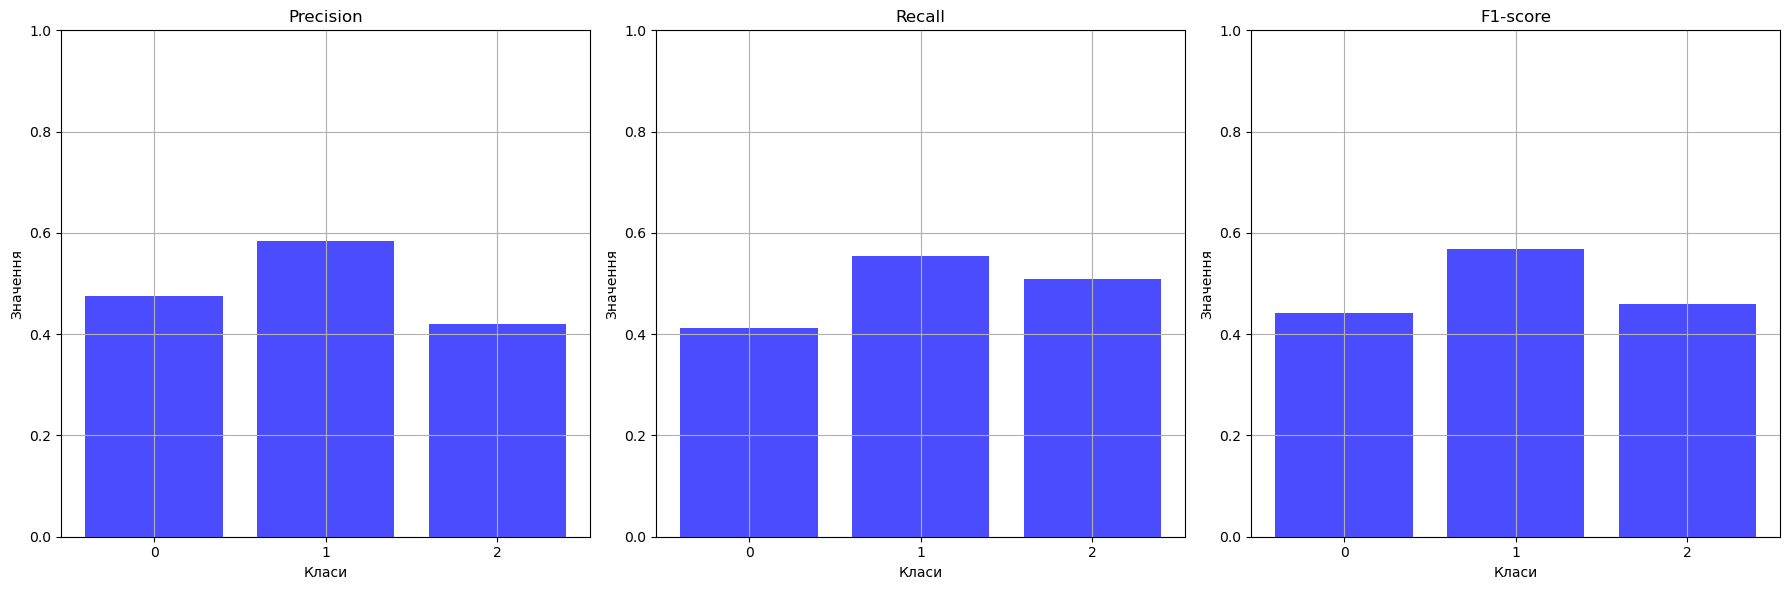

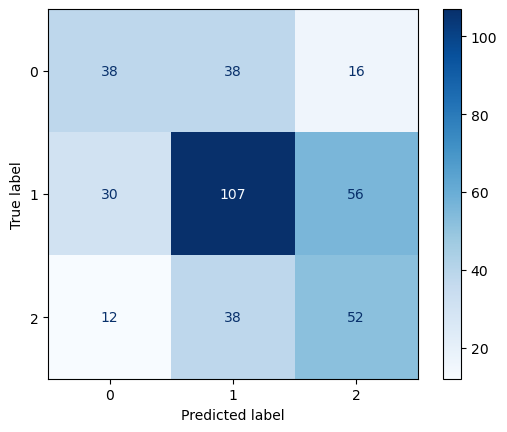

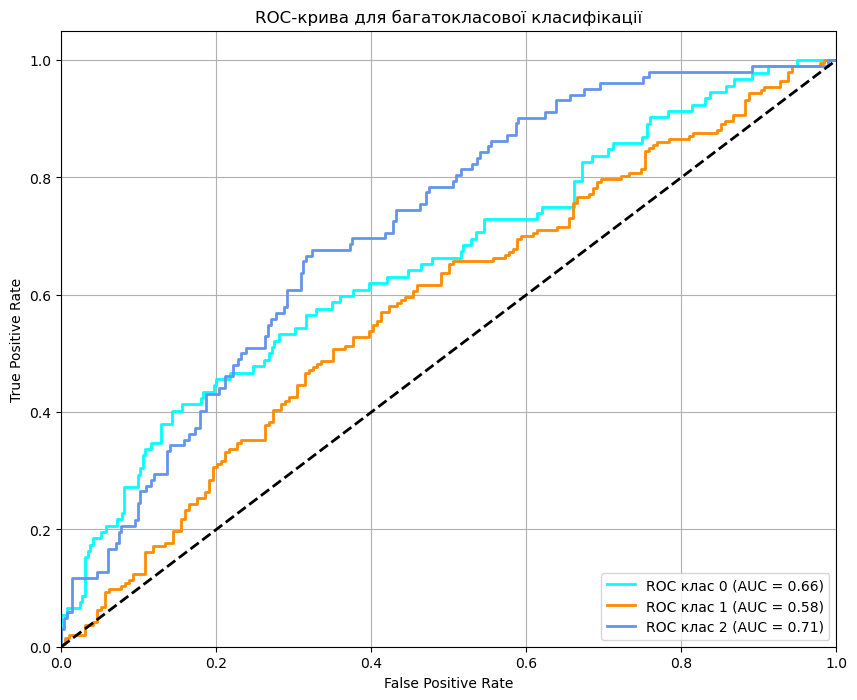

None


In [157]:
from sklearn.metrics import classification_report

best_model.fit(X_train_sel, y_train)
y_pred = best_model.predict(X_test_sel)
y_prob = best_model.predict_proba(X_test_sel)
print(statistics(y_test, y_pred, y_prob, 3))